In [18]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import fsspec
import os
from vcm.select import RegionOfInterest

kg_m2s_to_mm_day = (1e3 * 86400) / 997.0
kg_m2_to_mm  = 1000. / 997.0

import xarray as xr
import numpy as np
import fsspec
import intake
from vcm.catalog import catalog 
import fv3viz
import cftime
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import timedelta
import seaborn as sns
import vcm
from dask.diagnostics import ProgressBar


slmsk = catalog["landseamask/c48"].read()
grid = catalog["grid/c48"].read()
wind_rotation = catalog["wind_rotation/c48"].read()

figsize=(12,4)
col_wrap = 2
rename_dims = {"grid_xt": "x", "grid_yt": "y", "grid_y": "y_interface", "grid_x": "x_interface"}


In [19]:

labels = ["JFM", "AMJ", "JAS", "OND"]

def seasonal_avg(ds):
    seasonal_ = []
    start_year = ds.time.values[0].year
    seasons = [
        slice(cftime.DatetimeJulian(start_year,1,1), cftime.DatetimeJulian(start_year,4,1)),
        slice(cftime.DatetimeJulian(start_year,4,1), cftime.DatetimeJulian(start_year,7,1)),
        slice(cftime.DatetimeJulian(start_year,7,1), cftime.DatetimeJulian(start_year,10,1)),
        slice(cftime.DatetimeJulian(start_year,10,1), cftime.DatetimeJulian(start_year + 1, 1,1)),
    ]    
    for season in seasons:
        seasonal_.append(ds.sel(time=season).mean("time"))
    return xr.concat(seasonal_, dim=pd.Index([str(v) for v in labels], name="season")).load()
    

In [20]:
experiments = {
    "Baseline": "gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-10/baseline-seaice-prescribed",
    "ML ensemble": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-09/decrease-rad-lr-updated-rad-flux-ensemble",
    #"ML seed 0": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-0",
    #"ML seed 1": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-1",
    #"ML seed 2": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-2",
    #"ML seed 3": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-3"

}
reference_state = intake.open_zarr("gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-21/nudged-run/fv3gfs_run/reference_state.zarr/").to_dask()


In [21]:
names, data = [], []
for key, rundir in experiments.items():
    names.append(key)
    data.append(intake.open_zarr(os.path.join(rundir, "fv3gfs_run", "state_after_timestep.zarr")).to_dask())
prog_state = xr.concat(data, dim=pd.Index(names, name="run"))

In [22]:
with ProgressBar():
    seasonal_prog_state = seasonal_avg(prog_state).load()
    seasonal_reference_state = seasonal_avg(reference_state).load()

[########################################] | 100% Completed | 59min 42.3s
[########################################] | 100% Completed | 11min 15.8s


In [23]:
rename_ref = {
    v: v.split("_reference")[0] for v in seasonal_reference_state
}
seasonal_reference_state = seasonal_reference_state.rename(rename_ref)

center and rotate D-grid to A-grid winds

In [24]:
prog_a_grid_winds = vcm.DerivedMapping(seasonal_prog_state.merge(grid).merge(wind_rotation)).dataset(["northward_wind", "eastward_wind"])
ref_a_grid_winds = vcm.DerivedMapping(
    seasonal_reference_state.merge(grid).merge(wind_rotation)).dataset(["northward_wind", "eastward_wind"])


In [25]:
seasonal_prog_state = seasonal_prog_state.merge(prog_a_grid_winds)
seasonal_reference_state = seasonal_reference_state.merge(ref_a_grid_winds)

In [26]:
def plot_plev_bias(prog: xr.Dataset, ref: xr.Dataset, var: str, cbar_label: str=None, **kwargs):
    prog_plev = vcm.interpolate_to_pressure_levels(prog[var], prog["pressure_thickness_of_atmospheric_layer"], dim="z")
    ref_plev = vcm.interpolate_to_pressure_levels(ref[var], ref["pressure_thickness_of_atmospheric_layer"], dim="z")
    bias_plev = (prog_plev - ref_plev) \
        .rename(cbar_label) \
        .assign_coords({"pressure": ref_plev.pressure.values/100.}) \
        .rename({"pressure": "Pressure [hPa]"})
    
    f = vcm.zonal_average_approximate(
        grid.lat,
        bias_plev,
        lat_name="Latitude [deg]"
    ).plot(x="Latitude [deg]", yincrease=False, **kwargs)
    return f

#### Air temperature

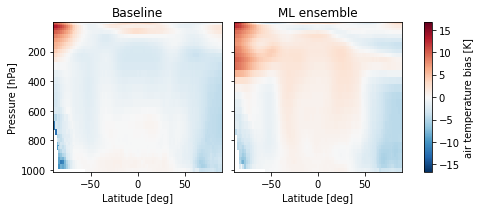

In [29]:
f = plot_plev_bias(seasonal_prog_state.mean("season"), seasonal_reference_state.mean("season"), "air_temperature", "air temperature bias [K]", col="run")

f.axes[0][0].set_title("Baseline")
f.axes[0][1].set_title("ML ensemble")

plt.savefig("figures/pdf/prognostic_zonal_pressure_bias_air_temperature.pdf", dpi=200)

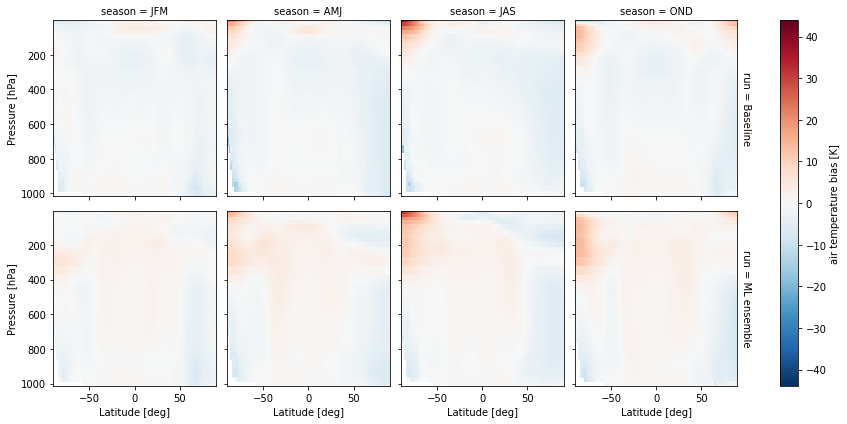

In [28]:
f = plot_plev_bias(seasonal_prog_state, seasonal_reference_state, "air_temperature", "air temperature bias [K]", col="season", row="run")


#### Specific humidity

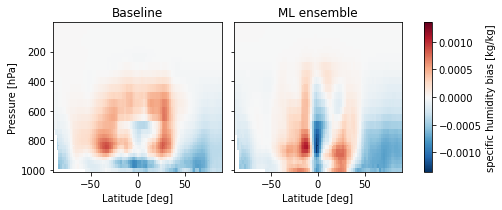

In [30]:
f = plot_plev_bias(seasonal_prog_state.mean("season"), seasonal_reference_state.mean("season"), "specific_humidity", "specific humidity bias [kg/kg]", col="run")

f.axes[0][0].set_title("Baseline")
f.axes[0][1].set_title("ML ensemble")

plt.savefig("figures/pdf/prognostic_zonal_pressure_bias_specific_humidity.pdf", dpi=200)

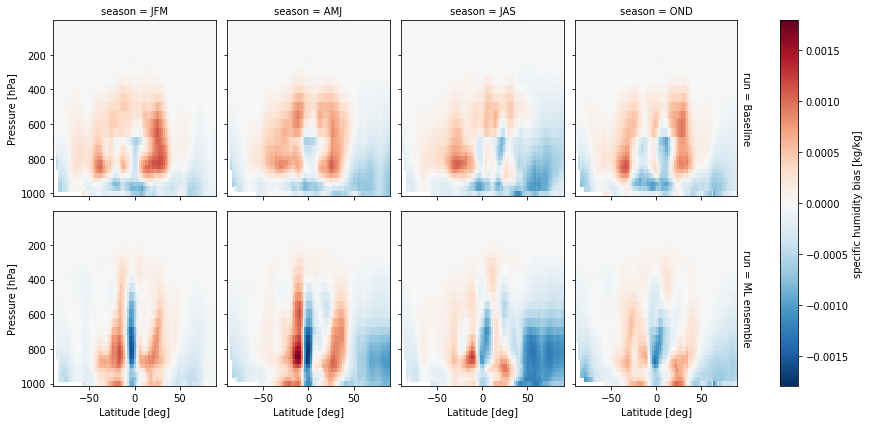

In [31]:
f = plot_plev_bias(seasonal_prog_state, seasonal_reference_state, "specific_humidity", "specific humidity bias [kg/kg]", col="season", row="run")


#### Zonal wind

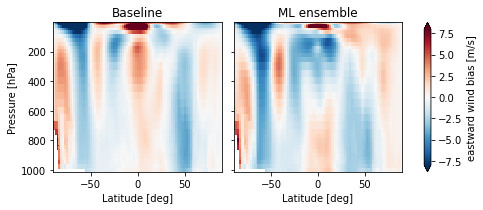

In [32]:
f = plot_plev_bias(seasonal_prog_state.mean("season"), seasonal_reference_state.mean("season"), "eastward_wind", "eastward wind bias [m/s]", col="run", vmax=8)

f.axes[0][0].set_title("Baseline")
f.axes[0][1].set_title("ML ensemble")

plt.savefig("figures/pdf/prognostic_zonal_pressure_bias_eastward_wind.pdf", dpi=200)

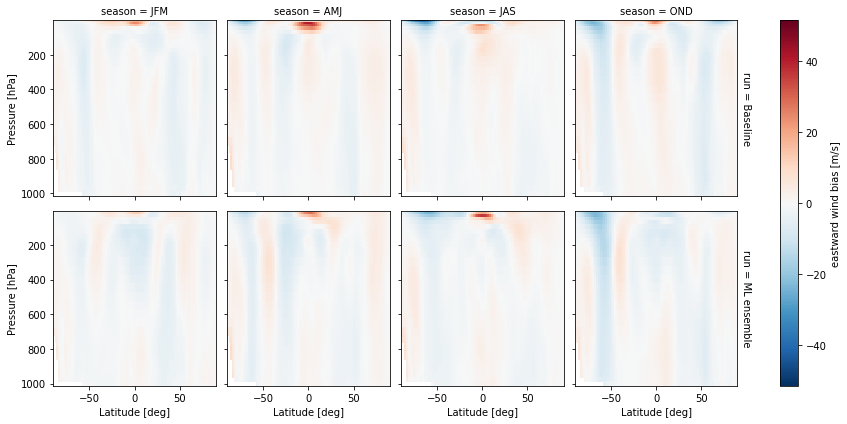

In [33]:
f = plot_plev_bias(seasonal_prog_state, seasonal_reference_state, "eastward_wind", "eastward wind bias [m/s]", col="season", row="run")


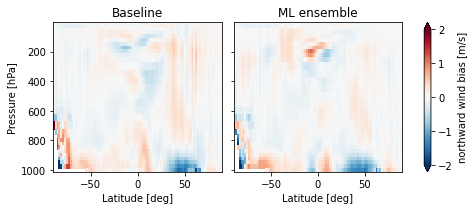

In [34]:
f = plot_plev_bias(seasonal_prog_state.mean("season"), seasonal_reference_state.mean("season"), "northward_wind", "northward wind bias [m/s]", col="run", vmax=2)

f.axes[0][0].set_title("Baseline")
f.axes[0][1].set_title("ML ensemble")

plt.savefig("figures/pdf/prognostic_zonal_pressure_bias_northward_wind.pdf", dpi=200)

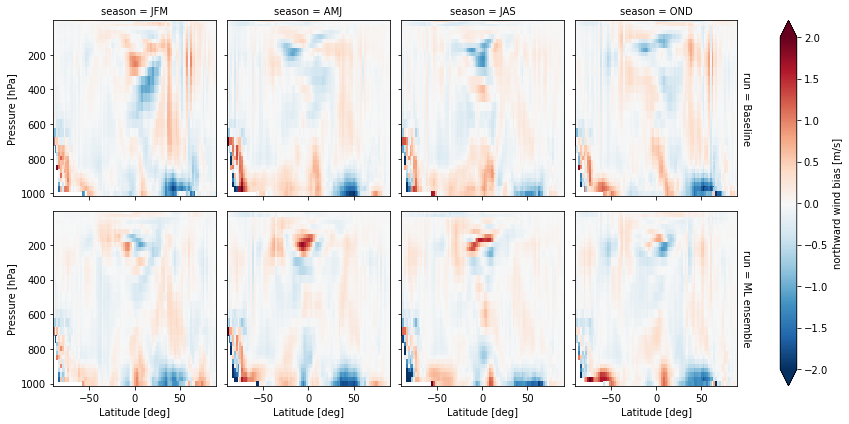

In [35]:
f = plot_plev_bias(seasonal_prog_state, seasonal_reference_state, "northward_wind", "northward wind bias [m/s]", col="season", row="run", vmax=2)

